In [1]:
import json
import string
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter
%matplotlib inline

from sklearn.metrics import recall_score, accuracy_score, precision_score, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import CountVectorizer


In [2]:
products = pd.read_csv('amazon_baby.csv')
products = products.fillna({'review':''})  # fill in N/A's in the review column

In [3]:
def remove_punctuation(text):
    # define punctuation
    punctuations = '''!()-[]{};:'"\,<>./?@#$%^&*_~+='''

    # remove punctuation from the string
    no_punct = ""
    for char in text:
        if char not in punctuations:
            no_punct = no_punct + char
        else:
            no_punct = no_punct + " "
            
    return no_punct

In [4]:
index=0
review_without_puctuation = pd.Series([])
for i in products['review']:
    review_without_puctuation[index] = remove_punctuation(i)
    index = index + 1

products.insert(products.shape[1], "review_clean", review_without_puctuation) 
products = products[products['rating'] != 3]
products['sentiment'] = products['rating'].apply(lambda rating : +1 if rating > 3 else -1)

In [5]:
#products.to_csv("products.csv", index = False, header = True)      #save to file to use later

In [6]:
with open('module-9-assignment-test-idx.json') as test_data_file:    
    test_data_idx = json.load(test_data_file)
    
with open('module-9-assignment-train-idx.json') as train_data_file:    
    train_data_idx = json.load(train_data_file)
    
train_data = products.iloc[train_data_idx]
test_data = products.iloc[test_data_idx]

Build the word count vector for each review :

In [7]:
vectorizer = CountVectorizer(token_pattern=r'\b\w+\b')
# Use this token pattern to keep single-letter words
# First, learn vocabulary from the training data and assign columns to words
# Then convert the training data into a sparse matrix
train_matrix = vectorizer.fit_transform(train_data['review_clean'].values.astype('U'))
# Second, convert the test data into a sparse matrix, using the same word-column mapping
test_matrix = vectorizer.transform(test_data['review_clean'].values.astype('U'))

Train a sentiment classifier with logistic regression :

In [8]:
model = LogisticRegression()
model.fit(train_matrix, train_data['sentiment'].values.astype('U'))

/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

Model Evaluation : Accuracy

In [9]:
accuracy = accuracy_score(y_true=test_data['sentiment'].to_numpy().astype('U'), y_pred=model.predict(test_matrix))
print ("Test Accuracy: %s" % accuracy)

Test Accuracy: 0.9324154067674586


Baseline: Majority class prediction 

In [10]:
baseline = len(test_data[test_data['sentiment'] == 1])/len(test_data)
print ("Baseline accuracy (majority class classifier): %s" % baseline)

Baseline accuracy (majority class classifier): 0.8427825773938085


Using accuracy as the evaluation metric, our logistic regression model was better than the baseline (majority class classifier) due to their accuracy: 

    logistic regression model accuracy : 0.9324154067674586
    Baseline                  accuracy : 0.8427825773938085

Confusion Matrix :

In [11]:
cmat = confusion_matrix(y_true=test_data['sentiment'].to_numpy().astype('U'),
                        y_pred=model.predict(test_matrix),
                        labels=model.classes_)    # use the same order of class as the LR model.
print (' target_label | predicted_label | count ')
print ('--------------+-----------------+-------')
# Print out the confusion matrix.
# NOTE: Your tool may arrange entries in a different order. Consult appropriate manuals.
for i, target_label in enumerate(model.classes_):
    for j, predicted_label in enumerate(model.classes_):
        print ('{0:^13} | {1:^15} | {2:5d}'.format(target_label, predicted_label, cmat[i,j]))

 target_label | predicted_label | count 
--------------+-----------------+-------
     -1       |       -1        |  3785
     -1       |        1        |  1456
      1       |       -1        |   797
      1       |        1        | 27298


false positives (predicted as positive which is negative) in the test set are : 1456

Computing the cost of mistakes :

In [12]:
FP = 1456
FN = 797

print ("the cost associated with the logistic regression classifier's performance on the test set is :", 100*FP +1*FN)

the cost associated with the logistic regression classifier's performance on the test set is : 146397


Precision and Recall :

In [13]:
precision = precision_score(y_true=test_data['sentiment'].to_numpy().astype('U'), y_pred=model.predict(test_matrix), pos_label = '1')
print ("Precision on test data: %s" % precision)

Precision on test data: 0.9493635668080963


In [14]:
print ("Out of all reviews in the test set that are predicted to be positive {:0.2f} of them are false positives.".format(1456/(1456+27298)))

Out of all reviews in the test set that are predicted to be positive 0.05 of them are false positives.


Based on what we learned in lecture, if we wanted to reduce this fraction of false positives to be below 3.5%, we would limited our positive predictions with lower threshold.

In [15]:
print ("{} of the positive reviews in the test_set were correctly predicted as positive by the classifier.".format(27298/(27298+1456)))

0.9493635668080963 of the positive reviews in the test_set were correctly predicted as positive by the classifier.


The recall value for a classifier that predicts +1 for all data points in the test_data is :

In [16]:
recall = recall_score(y_true=test_data['sentiment'].to_numpy().astype("U"), y_pred=model.predict(test_matrix), pos_label = '1')
print ("Recall on test data: %s" % recall)

Recall on test data: 0.9716319629827371


In [17]:
def apply_threshold(probabilities, threshold):
    
    output = []
    for i in range(len(probabilities)):
        if probabilities[i] < threshold :
            output.append(-1)
        else:
            output.append(1)
    return output

In [18]:
probabilities = model.predict_proba(test_matrix)[:,1]

low_threshold = apply_threshold(probabilities, 0.5)
low_dict_counter = Counter(low_threshold)

high_threshold = apply_threshold(probabilities, 0.9)
high_dict_counter = Counter(high_threshold)

In [19]:
print ("number of positive predicted reviews at threshold of 0.5 is :", low_dict_counter[1])

number of positive predicted reviews at threshold of 0.5 is : 28754


In [20]:
print ("number of positive predicted reviews at threshold of 0.9 is :", high_dict_counter[1])

number of positive predicted reviews at threshold of 0.9 is : 25002


The number of positive predicted reviews as the threshold increased from 0.5 to 0.9, will decreased.

Exploring the associated precision and recall as the threshold varies :

In [21]:
precision_of_low_threshold = precision_score(y_true=test_data['sentiment'].values, y_pred=low_threshold)
precision_of_high_threshold = precision_score(y_true=test_data['sentiment'].values, y_pred=high_threshold)
print("Precision altered from {} to {}".format(precision_of_low_threshold, precision_of_high_threshold))

Precision altered from 0.9493635668080963 to 0.9818414526837853


In [22]:
recall_of_low_threshold = recall_score(y_true=test_data['sentiment'].values, y_pred=low_threshold, pos_label=1)
recall_of_high_threshold = recall_score(y_true=test_data['sentiment'].values, y_pred=high_threshold, pos_label=1)
print("Recall altered from {} to {}".format(recall_of_low_threshold, recall_of_high_threshold))

Recall altered from 0.9716319629827371 to 0.8737497775404877


So it can seen clearly that precision increase, but recall decrease with a higher threshold.

Precision-recall curve :

In [23]:
threshold_values = np.linspace(0.5, 1, num=100)
print (threshold_values)

[0.5        0.50505051 0.51010101 0.51515152 0.52020202 0.52525253
 0.53030303 0.53535354 0.54040404 0.54545455 0.55050505 0.55555556
 0.56060606 0.56565657 0.57070707 0.57575758 0.58080808 0.58585859
 0.59090909 0.5959596  0.6010101  0.60606061 0.61111111 0.61616162
 0.62121212 0.62626263 0.63131313 0.63636364 0.64141414 0.64646465
 0.65151515 0.65656566 0.66161616 0.66666667 0.67171717 0.67676768
 0.68181818 0.68686869 0.69191919 0.6969697  0.7020202  0.70707071
 0.71212121 0.71717172 0.72222222 0.72727273 0.73232323 0.73737374
 0.74242424 0.74747475 0.75252525 0.75757576 0.76262626 0.76767677
 0.77272727 0.77777778 0.78282828 0.78787879 0.79292929 0.7979798
 0.8030303  0.80808081 0.81313131 0.81818182 0.82323232 0.82828283
 0.83333333 0.83838384 0.84343434 0.84848485 0.85353535 0.85858586
 0.86363636 0.86868687 0.87373737 0.87878788 0.88383838 0.88888889
 0.89393939 0.8989899  0.9040404  0.90909091 0.91414141 0.91919192
 0.92424242 0.92929293 0.93434343 0.93939394 0.94444444 0.94949

In [24]:
def plot_pr_curve(precision, recall, title):
    plt.rcParams['figure.figsize'] = 7, 5
    plt.locator_params(axis = 'x', nbins = 5)
    plt.plot(precision, recall, 'b-', linewidth=4.0, color = '#B0017F')
    plt.title(title)
    plt.xlabel('Precision')
    plt.ylabel('Recall')
    plt.rcParams.update({'font.size': 16})

In [25]:
precision_all = []
recall_all = []

probabilities = model.predict_proba(test_matrix)[:,1]
for threshold in threshold_values:
    predictions = apply_threshold(probabilities, threshold)
    
    precision = precision_score(y_true=test_data['sentiment'].values, y_pred=predictions)
    recall = recall_score(y_true=test_data['sentiment'].values, y_pred=predictions)
    
    precision_all.append(precision)
    recall_all.append(recall)

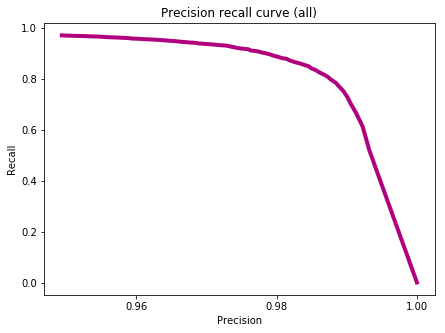

In [26]:
plot_pr_curve(precision_all, recall_all, 'Precision recall curve (all)')

In [27]:
print("Among all the threshold values tried, the smallest threshold value that achieves a precision of 96.5% or better is {:.3f}".format(min(np.array(threshold_values)[np.array(precision_all) >= 0.965])))

Among all the threshold values tried, the smallest threshold value that achieves a precision of 96.5% or better is 0.702


In [28]:
threshold_98 = apply_threshold(probabilities, 0.98)

confusion_matrix_98 = confusion_matrix(y_true=test_data['sentiment'].values,
                        y_pred=threshold_98,
                        labels=[-1, 1])
print (' target_label | predicted_label | count ')
print ('--------------+-----------------+-------')

for i, target_label in enumerate(model.classes_):
    for j, predicted_label in enumerate(model.classes_):
        print ('{0:^13} | {1:^15} | {2:5d}'.format(target_label, predicted_label, confusion_matrix_98[i,j]))

 target_label | predicted_label | count 
--------------+-----------------+-------
     -1       |       -1        |  5054
     -1       |        1        |   187
      1       |       -1        |  8358
      1       |        1        | 19737


Using threshold = 0.98, there are 8358 false negatives on the test_data.

Precision-Recall on all baby related items :

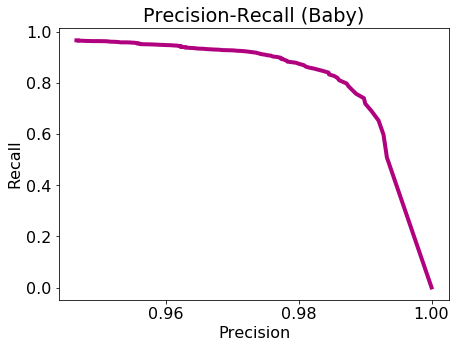

In [31]:
baby_reviews =  test_data[test_data['name'].apply(lambda x: 'baby' in str(x).lower())]
baby_matrix = vectorizer.transform(baby_reviews['review_clean'])

probabilities = model.predict_proba(baby_matrix)[:,1]

threshold_values = np.linspace(0.5, 1, num=100)

precision_all = []
recall_all = []
for threshold in threshold_values:
    
    predictions = apply_threshold(probabilities, threshold)

    precision = precision_score(y_true=baby_reviews['sentiment'].values, y_pred=predictions)
    recall = recall_score(y_true=baby_reviews['sentiment'].values, y_pred=predictions)
    
    precision_all.append(precision)
    recall_all.append(recall)
    
plot_pr_curve(precision_all, recall_all, "Precision-Recall (Baby)")

In [32]:
print("Among all the threshold values tried, the smallest threshold value that achieves a precision of 96.5% or better is {:.3f}".format(min(np.array(threshold_values)[np.array(precision_all) >= 0.965])))

Among all the threshold values tried, the smallest threshold value that achieves a precision of 96.5% or better is 0.742
